## College Dropout Prediction with SVM | CS 4262
By: Karen

Date: April 25, 2024

We utilize a combination of PCA and SVM to predict student retention utilizing a dataset from Kaggle.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score
from matplotlib.colors import ListedColormap

In [2]:
data = pd.read_csv("./sample_data/dropout_data.csv")

## Preprocessing and Parameters

In [3]:
data = data.dropna()
processed_data = data[~data["Target"].str.contains("Enroll")]
processed_data.drop(['International',
           'Nacionality',
           "Mother's qualification",
           "Curricular units 1st sem (evaluations)",
           "Mother's occupation",
           "Father's occupation",
           "Father's qualification",
           'Unemployment rate',
           "Application order",
           "GDP",
           'Inflation rate'],axis=1,inplace=True)

df = (pd.DataFrame(processed_data['Target'].apply(lambda x: 0 if x == "Dropout" else 1))).to_numpy()
exploration_data = processed_data.drop('Target', axis=1).values

<ipython-input-3-2f7ba3cd9094>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data.drop(['International',


In [4]:
def run_SVM(input, C, gamma):
  performance = []
  kFold=KFold(n_splits=5,shuffle=False)
  for train_index,test_index in kFold.split(input):
      X_train, X_test, y_train, y_test = input[train_index], input[test_index], df[train_index], df[test_index]

      # run SVM
      sv = SVC(C=C, gamma=gamma)
      sv.fit(X_train, y_train.ravel())

      # performance
      y_pred = sv.predict(X_test)
      performance.append(accuracy_score(y_test, y_pred))

  # Calculate the average accuracy across all folds
  avg = np.mean(performance)
  return avg

In [5]:
# testing parameters
C = [0.001, 0.01, 0.1, 1, 10, 100]
gamma_val = [0.001, 0.01, 0.1, 1, 10, 100]

all_combos = []
for c in C:
  for gamma in gamma_val:
    score = run_SVM(exploration_data, c, gamma)
    all_combos.append([c, gamma, score])

In [6]:
# get the best combo
params = pd.DataFrame(all_combos, columns = ['C', 'gamma', 'score'])
(params.sort_values(by=['score'], ascending=False)).head()

,C,gamma,score
24,10.0,0.001,0.911019
30,100.0,0.001,0.909366
25,10.0,0.010,0.898347
18,1.0,0.001,0.893113
19,1.0,0.010,0.892287


Overall, there are 34 features in this dataset, each represented numerically, whether they are categorical or continuous. We filtered it down to 23. The best parameters for original features are C = 10 and gamma = 0.001.

## PCA

In [7]:
# Perform feature scaling prior to PCA
# mean center the data and divide by the standard deviation
def feature_scale(X):
    # X_scaled = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    # return X_scaled
    return X

data_scaled = feature_scale(exploration_data[:, 1:])

# Perform PCA
data_cov = np.cov(data_scaled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(data_cov)

# Sort the eigenvectors by decreasing eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigvals = eigenvalues[sorted_indices]
sorted_eigvecs = eigenvectors[:, sorted_indices]

# Calculate the explained variance
explained_variance = sorted_eigvals / np.sum(sorted_eigvals)

# Calculate the cumulative explained variance for each number of components
cumulative_explained_variance = np.cumsum(explained_variance)


first_20_explained_variance = cumulative_explained_variance[19]
first_12_explained_variance = cumulative_explained_variance[11]
print(f'The first 20 principal components explain {first_20_explained_variance * 100:.2f} of the variance.')
print(f'The first 12 principal components explain {first_12_explained_variance * 100:.2f}% of the variance.')



The first 20 principal components explain 99.97 of the variance.
The first 12 principal components explain 99.41% of the variance.


In [8]:
# top_20_eigvecs = sorted_eigvecs[:, :10]
top_eigvecs = sorted_eigvecs[:, :12]

# Project the data onto the top 20 eigenvectors
data_proj = np.dot(data_scaled, top_eigvecs)

# Reconstruct the data using the top 20 eigenvectors
input = np.dot(data_proj, top_eigvecs.T)

In [9]:
# testing parameters
C = [0.001, 0.01, 0.1, 1, 10, 100]
gamma_val = [0.001, 0.01, 0.1, 1, 10, 100]

all_combos = []
for c in C:
  for gamma in gamma_val:
    score = run_SVM(input, c, gamma)
    all_combos.append([c, gamma, score])

In [10]:
# get the best combo
params = pd.DataFrame(all_combos, columns = ['C', 'gamma', 'score'])
(params.sort_values(by=['score'], ascending=False)).head()

,C,gamma,score
24,10.0,0.001,0.896419
30,100.0,0.001,0.894490
18,1.0,0.001,0.887603
25,10.0,0.010,0.886777
19,1.0,0.010,0.885124


The best parameters for original features are C = 10 and gamma = 0.001.

##Implement SVM to classify Graduate or Dropout

In [11]:
# K fold cross validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

svm_model = SVC(C=10, gamma=0.001)

In [12]:
# scores w PCA
scores = cross_val_score(svm_model, data_proj, processed_data['Target'], cv=kf)

# confusion matrix
y_pred = cross_val_predict(svm_model, data_proj, processed_data['Target'], cv=kf)
cm = confusion_matrix(processed_data['Target'], y_pred)

# metrics
report = classification_report(processed_data['Target'], y_pred)

In [13]:
print(np.mean(scores))
print(cm)
print(report)

0.8975206611570249
[[1135  286]
 [  86 2123]]
              precision    recall  f1-score   support

     Dropout       0.93      0.80      0.86      1421
    Graduate       0.88      0.96      0.92      2209

    accuracy                           0.90      3630
   macro avg       0.91      0.88      0.89      3630
weighted avg       0.90      0.90      0.90      3630



In [14]:
# without PCA
scores = cross_val_score(svm_model, data_scaled, processed_data['Target'], cv=kf)

# confusion matrix
y_pred = cross_val_predict(svm_model, data_scaled, processed_data['Target'], cv=kf)
cm = confusion_matrix(processed_data['Target'], y_pred)

# metrics
report = classification_report(processed_data['Target'], y_pred)

In [15]:
print(np.mean(scores))
print(cm)
print(report)

0.908815426997245
[[1159  262]
 [  69 2140]]
              precision    recall  f1-score   support

     Dropout       0.94      0.82      0.88      1421
    Graduate       0.89      0.97      0.93      2209

    accuracy                           0.91      3630
   macro avg       0.92      0.89      0.90      3630
weighted avg       0.91      0.91      0.91      3630



## Graphs

<ipython-input-16-34080e2ba258>:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


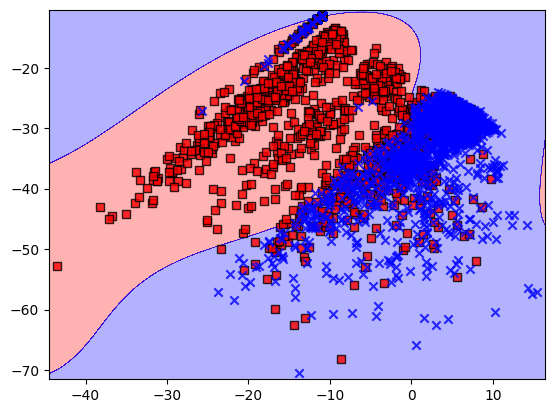

In [16]:
# The following code will plot the decision boundary on a dataset for a given classifier.
# source: https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch02/ch02.ipynb
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # set up marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')


# plot decision boundary for first two PCA features
sv = SVC(C=10, gamma=0.001)
sv.fit(data_proj[:,:2], df.ravel())
plot_decision_regions(data_proj[:,:2], df.ravel(), sv)

Acknowledgements:
- ChatGPT 3.5
- Assignment 3 (GDA and SVM assignment)
- [Student Retention Dataset](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention?resource=download)
- [paper](https://www.mdpi.com/1912602)